In [ ]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15521, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 15521 (delta 0), reused 5 (delta 0), pack-reused 15514
Receiving objects: 100% (15521/15521), 14.19 MiB | 19.69 MiB/s, done.
Resolving deltas: 100% (10412/10412), done.


In [ ]:
%cd /content/darknet

/content/darknet


In [ ]:
# change makefile to have GPU,OPENCV, CUDNN enabled
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

In [ ]:
#Compile Sources
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -rdynamic -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
  946 |                 float rgb[3];
      |                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
 1147 |             if (iteration_old == 

In [ ]:
# get yolov3 pretrained coco dataset weights
!wget https://pjreddie.com/media/files/yolov3.weights

--2023-05-24 01:44:28--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  41.2MB/s    in 6.2s    

2023-05-24 01:44:35 (38.3 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [ ]:
import cv2
import IPython
import numpy as np
import time
import math
from google.colab.patches import cv2_imshow


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
min_confidence = 0.5
weight_file = 'yolov3.weights'
cfg_file = 'cfg/yolov3.cfg'
name_file = 'data/coco.names'

file_name = 'cabc30fc-e7726578.mp4'

In [ ]:
# Load Yolo
net = cv2.dnn.readNet(weight_file, cfg_file)

In [ ]:
classes = []
with open(name_file, 'r') as f:
    classes = [line.strip() for line in f.readlines()]
print(classes)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [ ]:
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

In [ ]:
# cabc30fc-e7726578.mp4

# from google.colab import files
# files.upload()

In [ ]:
def writeFrame(img):
    # use global variable, writer
    global writer
    height, width = img.shape[:2]
    if writer is None and output_name is not None:
        fourcc = cv2.VideoWriter_fourcc(*'MJPG')
        writer = cv2.VideoWriter(output_name, fourcc, 24, (width, height), True)
    if writer is not None:
        writer.write(img)

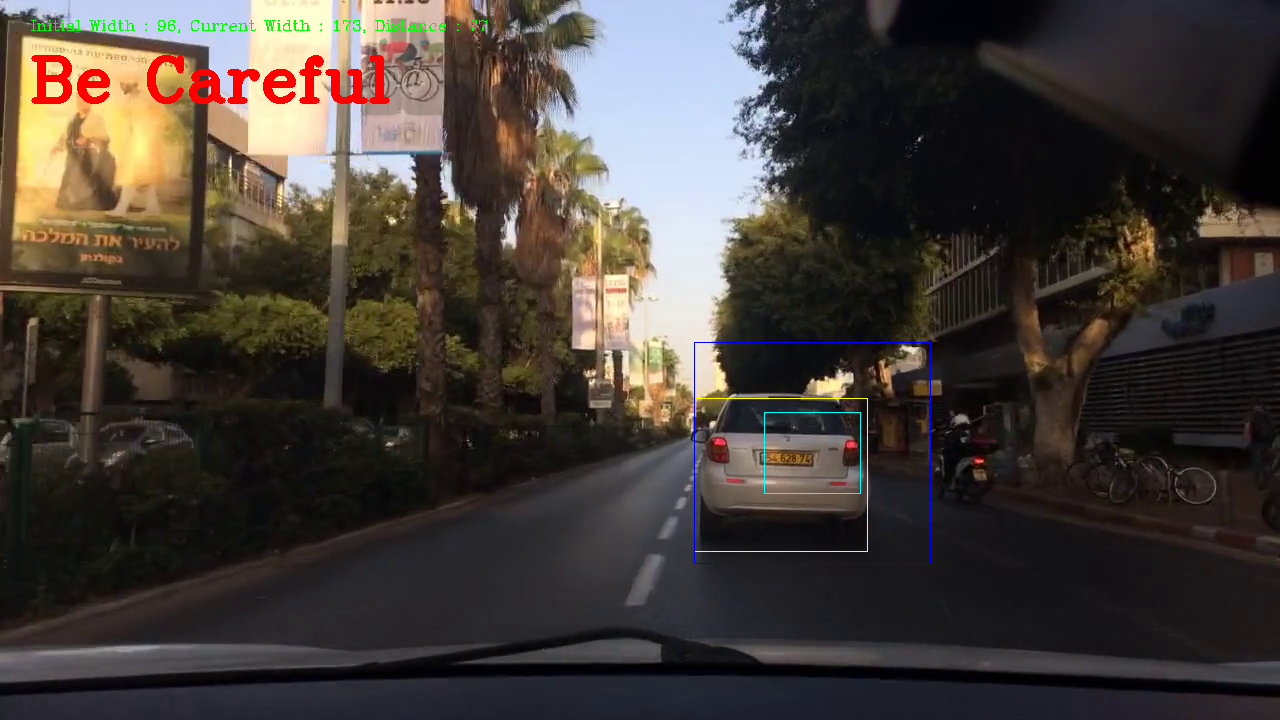

[Tracking] Frame 1203 time 1.1739914417266846
### No more frame ###
Elapsed time 1559.8972809314728


In [ ]:
frame_count = 0
# initialize the video writer 
writer = None
output_name = 'output_car_tracking.avi'

detected = False
frame_mode = 'Tracking'
elapsed_time = 0
margin = 70
tracker = cv2.legacy_TrackerMOSSE.create()
trackers = cv2.legacy.MultiTracker_create()

detected_width = 0
vs = cv2.VideoCapture(file_name)

while True:
    start_time = time.time()
    frame_count += 1
    ret, frame = vs.read()
    if frame is None:
        print('### No more frame ###')
        break
    IPython.display.clear_output(wait=True)
    height, width, channedls = frame.shape

    class_ids = []
    confidences = []
    boxes = []
    roi_left = int(0.3 * width)
    roi_right = int(0.6 * width)

    if detected:
        frame_mode = 'Tracking'
        (success, tracking_boxes) = trackers.update(frame)
        tracking_box = tracking_boxes[0]
        tx = int(tracking_box[0])
        ty = int(tracking_box[1])
        tw = int(tracking_box[2])
        th = int(tracking_box[3])
        roi = frame[ty-margin:ty+th+margin, tx-margin:tx+tw+margin]
        roi_width, roi_height = roi.shape[:2]
        blob = cv2.dnn.blobFromImage(roi, 0.00392, (416, 416), (0, 0, 0), True, crop=False)

        net.setInput(blob)
        outs = net.forward(output_layers)

        for out in outs:
            for detection in out:
                scores = detection[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]
                if (confidence > min_confidence) and (class_id == 2):
                    center_x = int(detection[0] * roi_width)
                    center_y = int(detection[1] * roi_height)
                    w = int(detection[2] * roi_width)
                    h = int(detection[3] * roi_height)

                    x = int(center_x - w / 2)
                    y = int(center_y - h / 2)
                    boxes.append([x, y, w, h])
        if len(boxes):
            boxes.sort(key=lambda x: x[2], reverse=True)
            box = boxes[0]
            x = box[0]
            y = box[1]
            w = box[2]
            h = box[3]
            roi_x = tx-margin + x
            roi_y = ty-margin + y
            distance_width = w - detected_width
            cv2.rectangle(frame, (roi_x, roi_y), (roi_x + w, roi_y + h), (0, 255, 255), 1)
            label = 'Initial Width : ' + str(detected_width) + ', Current Width : ' + str(w) + ', Distance : ' + str(w-detected_width)
            print(box, label)
            if abs(distance_width) > 5:
                if distance_width < 0:
                    cv2.putText(frame, 'Speed up', (30, 100), cv2.FONT_HERSHEY_COMPLEX, 2, (255, 0, 0), 5)
                elif distance_width < 30:
                    cv2.putText(frame, 'Slow down', (30, 100), cv2.FONT_HERSHEY_COMPLEX, 2, (0, 128, 255), 5)
                else:
                    cv2.putText(frame, 'Be Careful', (30, 100), cv2.FONT_HERSHEY_COMPLEX, 2, (0, 0, 255), 5)
            cv2.putText(frame, label, (30, 30), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 255, 0), 1) 
        cv2.rectangle(frame, (tx, ty), (tx+tw, ty+th), (255, 255, 0), 1)
        cv2.rectangle(frame, (tx-margin, ty-margin), (tx+tw+margin, ty+th+margin), (255, 0, 0), 1)  
          

    else:
        frame_mode = 'Detection'

        blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)

        net.setInput(blob)
        outs = net.forward(output_layers)

        for out in outs:
            for detection in out:
                scores = detection[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]
                if (confidence > min_confidence) and (class_id == 2):
                    center_x = int(detection[0] * width)
                    center_y = int(detection[1] * height)
                    w = int(detection[2] * width)
                    h = int(detection[3] * height)

                    x = int(center_x - w / 2)
                    y = int(center_y - h / 2)

                    boxes.append([x, y, w, h])
                    confidences.append(float(confidence))
                    class_ids.append(class_id)

        indexes = cv2.dnn.NMSBoxes(boxes, confidences, min_confidence, 0.4)
        font = cv2.FONT_HERSHEY_COMPLEX
        for i in range(len(boxes)):
            if i in indexes:
                x, y, w, h = boxes[i]
                if (w > 50) and (x > roi_left) and (x < roi_right):
                    selected = boxes[i]
                    detected_width = w
                    cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 255), 5)    
        trackers.add(tracker, frame, tuple(selected))
        detected = True 
  
    # mask = np.zeros((height,width), dtype='uint8')
    # poly_top = int(0.65 * height)
    # poly_bottom = int(0.85 * height)
    # poly_left = int(0.47 * width)
    # poly_right = int(0.53 * width)
    # roi_left = int(0.3 * width)
    # roi_right = int(0.6 * width)
    # poly_margin = 50
    # polygons = np.array([[(0+poly_margin,poly_bottom), (poly_left, poly_top), (poly_right, poly_top), (width-poly_margin, poly_bottom)]])
    # cv2.fillPoly(mask, polygons, 255)

    # indexes = cv2.dnn.NMSBoxes(boxes, confidences, min_confidence, 0.4)
    # font = cv2.FONT_HERSHEY_COMPLEX
    # margin = 5
    # for i in range(len(boxes)):
    #     if i in indexes:
    #         x, y, w, h = boxes[i]
    #         box = np.array([[(x-margin, y+h+margin), (x-margin, y-margin), (x+w+margin, y), (x+w+margin, y+h+margin)]])
    #         cv2.fillPoly(mask, box, 0) 
    #         if (w > 50) and (x > roi_left) and (x < roi_right):
    #             label = str(classes[class_ids[i]])
    #             print(class_ids[i], label, w)
    #             cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
    #             cv2.putText(frame, label, (x, y + 30), font, 0.5, (0, 255, 0), 1) 

  
    # gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    # blur = cv2.GaussianBlur(gray, (5, 5), 0)
    # canny = cv2.Canny(blur, 40, 130)

    # masked = cv2.bitwise_and(canny, mask)
  
    # lines = cv2.HoughLinesP(masked, 2, np.pi / 180, 20, np.array([]), 20, 10)
    # if lines is not None:
    #     for line in lines:
    #         for x1, y1, x2, y2 in line:
    #             cv2.line(frame, (x1,y1), (x2,y2), (0,  255, 255), 5)

    cv2_imshow(frame)
    writeFrame(frame)
    frame_time = time.time() - start_time
    elapsed_time += frame_time
    print("[{}] Frame {} time {}".format(frame_mode, frame_count, frame_time))

print("Elapsed time {}".format(elapsed_time))
vs.release()          

In [ ]:
from google.colab import files
files.download(output_name)

In [ ]:
cv2.__version__